In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/Bump10MSun`


In [2]:
using ArviZ
using Bump10MSun
using DimensionalData
using Distributions
using HDF5
using LaTeXStrings
using Printf
using MCMCChains
using MCMCChainsStorage
using MCMCDiagnosticTools
using StatsBase
using StatsPlots
using Trapz

Here we are fitting 
$$
\frac{\mathrm{d} N}{\mathrm{d} m_1 \mathrm{d} m_2 \mathrm{d} V \mathrm{d} t} = \frac{R}{m_1 m_2} g\left( q \right) f\left( m_1 \right) f\left( m_2 \right)
$$
where the "common" mass function
$$
f\left( m \right) = \begin{cases}
\left( \frac{m}{m_{b,12}} \right)^{\alpha_1} & m < m_{b,12} \\
\left( \frac{m}{m_{b,12}}\right)^{\alpha_2} & m_{b,12} < m < m_{b,23} \\
\left( \frac{m}{m_{b,12}} \right)^{\alpha_3} \left( \frac{m_{b,23}}{m_{b,12}} \right)^{\alpha_2 - \alpha_3} & m \geq m_{b,23}
\end{cases}
$$
and the "pairing" function is a Gaussian in mass ratio, given by 
$$
g\left( q \right) = \exp\left( - \frac{\left( q - \mu_q \right)^2}{2 \sigma_q^2} + \frac{\left( 1 - \mu_q \right)^2}{2 \sigma_q^2}\right)
$$
for 
$$
3 \, M_\odot < m_2 < m_1 < 20 \, M_\odot.
$$
Note: the definition above implies that $R$ is the volumetric merger rate per log mass squared at $m_1 = m_2 = m_{b,12}$.

We restrict 
$$
4 < m_{b,12} / M_\odot < 7
$$
because we are looking for a power-law break at low masses; presumably $m_{b,23}$ will then be located around the $9.5 \, M_\odot$ peak already identified.

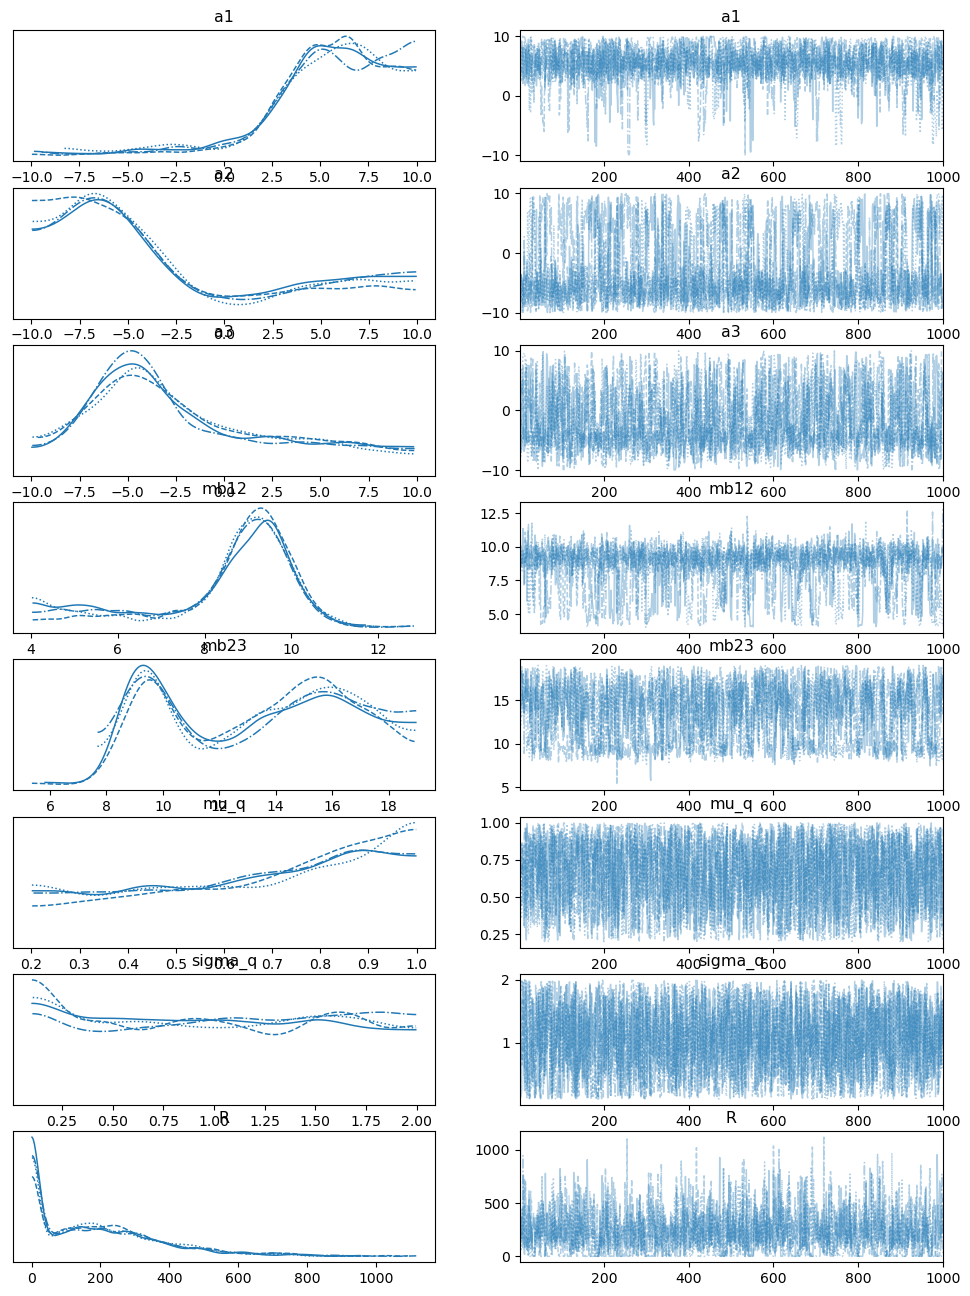

8×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ a1          5.501    3.187    0.306    9.998      0.104    0.073    104 ⋯
   2 │ a2         -3.163    5.755   -9.992    8.104      0.27     0.191     64
   3 │ a3         -1.998    4.869   -9.38     7.75       0.153    0.108    112
   4 │ mb12        8.523    1.646    4.579   10.637      0.078    0.055     63
   5 │ mb23       13.401    3.252    8.454   18.561      0.147    0.104     54 ⋯
   6 │ mu_q        0.662    0.232    0.266    1.0        0.005    0.003    219
   7 │ sigma_q     1.035    0.559    0.101    1.875      0.011    0.008    216
   8 │ R         214.916  186.438    0.0    540.561      6.136    4.34      64
                                                               3 columns omitted

In [3]:
trace = from_netcdf(joinpath(@__DIR__, "..", "chains", "chain_tb.nc"))
var_names = map(String, [:a1, :a2, :a3, :mb12, :mb23, :mu_q, :sigma_q, :R])
plot_trace(trace, var_names=var_names)
summarystats(trace, var_names=var_names)

In [6]:
post = trace.posterior
all_vars_post = map(k -> post[k], [:a1, :a2, :a3, :mb12, :mb23, :mu_q, :sigma_q, :R])
dNdm1dm2 = map(all_vars_post...) do a1, a2, a3, mb12, mb23, mu_q, sigma_q, R
    ldN = make_log_dN(a1, a2, a3, mb12, mb23, mu_q, sigma_q)
    (m1, m2) -> R*exp(ldN(m1,m2))
end
dNdm1 = map(all_vars_post...) do a1, a2, a3, mb12, mb23, mu_q, sigma_q, R
    dN = make_dNdm1(a1, a2, a3, mb12, mb23, mu_q, sigma_q)
    m1 -> R*dN(m1)
end
dNdm2 = map(all_vars_post...) do a1, a2, a3, mb12, mb23, mu_q, sigma_q, R
    dN = make_dNdm2(a1, a2, a3, mb12, mb23, mu_q, sigma_q)
    m2 -> R*dN(m2)
end
dNdq = map(all_vars_post...) do a1, a2, a3, mb12, mb23, mu_q, sigma_q, R
    dN = make_dNdq(a1, a2, a3, mb12, mb23, mu_q, sigma_q)
    q -> R*dN(q)
end
dNdm_pl = map(all_vars_post...) do a1, a2, a3, mb12, mb23, mu_q, sigma_q, R
    dN = make_dNdm(a1, a2, a3, mb12, mb23)
    m -> R*dN(m)
end
pprob = map(post.mu_q, post.sigma_q) do mu_q, sigma_q
    pf = make_pairing_prob(mu_q, sigma_q)
    q -> pf(q)
end;

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106


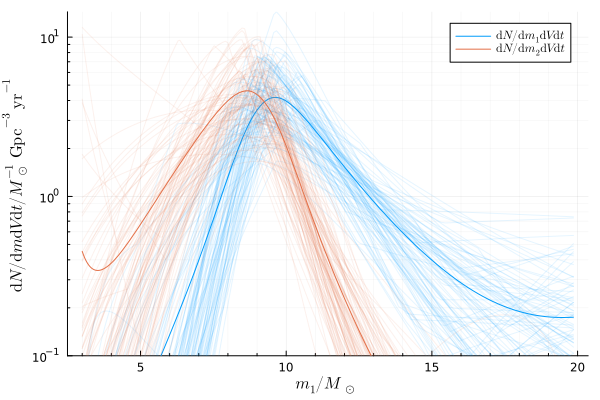

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106


In [7]:
ms = exp.(log(mlow):0.01:log(mhigh))
dN1_mean = zeros(length(ms))
dN2_mean = zeros(length(ms))

p = plot()

for dN in dNdm1
    dN1_mean = dN1_mean .+ dN.(ms)
end
dN1_mean = dN1_mean ./ length(dNdm1)
p = plot!(ms, dN1_mean, yscale=:log10, ylims=(0.1, Inf), xlabel=L"m_1 / M_\odot", ylabel=L"\mathrm{d} N / \mathrm{d}m \mathrm{d} V \mathrm{d} t / M_\odot^{-1}\, \mathrm{Gpc}^{-3}\, \mathrm{yr}^{-1}", label=L"\mathrm{d}N/\mathrm{d}m_1\mathrm{d}V\mathrm{d}t", minorgrid=true)
for _ in 1:100
    p = plot!(ms, sample(dNdm1).(ms), color=1, alpha=0.1, label=nothing)
end

for dN in dNdm2
    dN2_mean = dN2_mean .+ dN.(ms)
end
dN2_mean = dN2_mean ./ length(dNdm1)
p = plot!(ms, dN2_mean, color=2, yscale=:log10, ylims=(0.1, Inf), xlabel=L"m_1 / M_\odot", ylabel=L"\mathrm{d} N / \mathrm{d}m \mathrm{d} V \mathrm{d} t / M_\odot^{-1}\, \mathrm{Gpc}^{-3}\, \mathrm{yr}^{-1}", label=L"\mathrm{d}N/\mathrm{d}m_2 \mathrm{d}V\mathrm{d}t")
for _ in 1:100
    p = plot!(ms, sample(dNdm2).(ms), color=2, alpha=0.1, label=nothing)
end

p

How about the "common" part of the mass function?

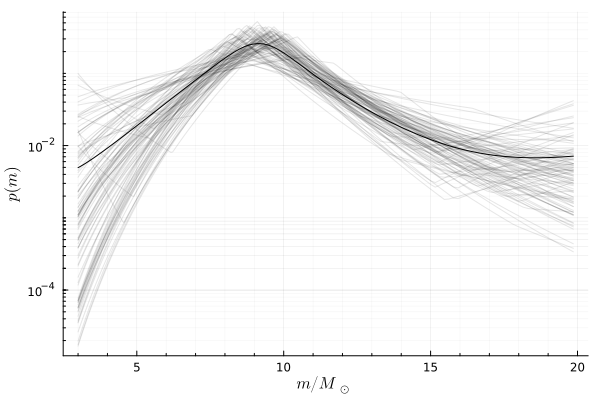

In [8]:
p = plot(xlabel=L"m/M_\odot", ylabel=L"p(m)", yscale=:log10, minorgrid=true)
dN_mean = zeros(length(ms))

for dN in dNdm_pl
    dN_mean = dN_mean .+ dN.(ms)
end
dN_mean = dN_mean ./ length(dNdm_pl)
dN_mean = dN_mean ./ trapz(ms, dN_mean)

p = plot!(ms, dN_mean, color=:black, label=nothing)
for _ in 1:100
    pp = sample(dNdm_pl).(ms)
    pp = pp ./ trapz(ms, pp)
    p = plot!(ms, pp, color=:black, alpha=0.1, label=nothing)
end
p

Let's look at $\mathrm{d} N/\mathrm{d} q$:

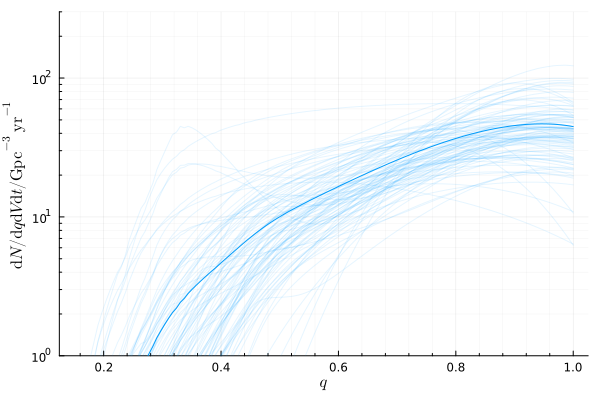

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106


In [9]:
qs = collect(range(mlow/mhigh, stop=1, length=128))
dNdq_mean = zeros(length(qs))

for dN in dNdq
    dNdq_mean .= dNdq_mean .+ dN.(qs)
end
dNdq_mean .= dNdq_mean ./ length(dNdq)
p = plot(qs, dNdq_mean, color=1, yscale=:log10, ylims=(1e0, 3e2), legend=nothing, minorgrid=true, xlabel=L"q", ylabel=L"\mathrm{d}N/\mathrm{d}q\mathrm{d}V\mathrm{d}t / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}")

for _ in 1:100
    p = plot!(qs, sample(dNdq).(qs), color=1, alpha=0.1)
end

p

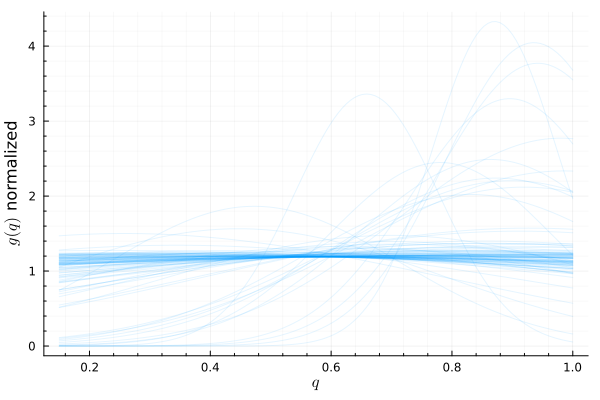

In [10]:
pp = plot(xlabel=L"q", ylabel=L"$g(q)$ normalized", legend=nothing, minorgrid=true)
for _ in 1:100
    p = sample(pprob)
    pb = p.(qs)
    pb /= trapz(qs, pb)
    pp = plot!(qs, pb, color=1, alpha=0.1, label=nothing)
end
pp

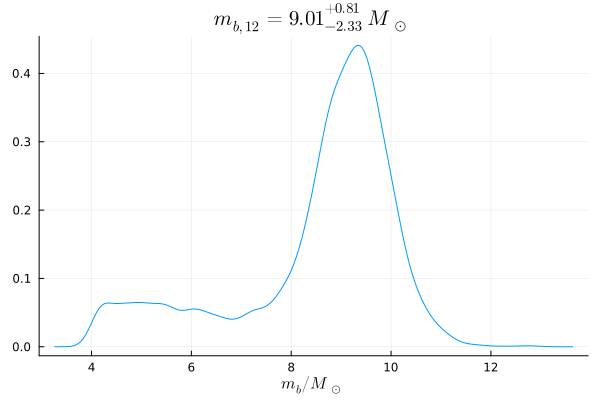

In [11]:
x = vec(trace.posterior[:mb12])
l = quantile(x, 0.16)
m = quantile(x, 0.5)
h = quantile(x, 0.84)

p = density(x, xlabel=L"m_b / M_\odot", label=nothing)
p = title!(@sprintf("\$m_{b,12} = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", m, h-m, m-l))

p

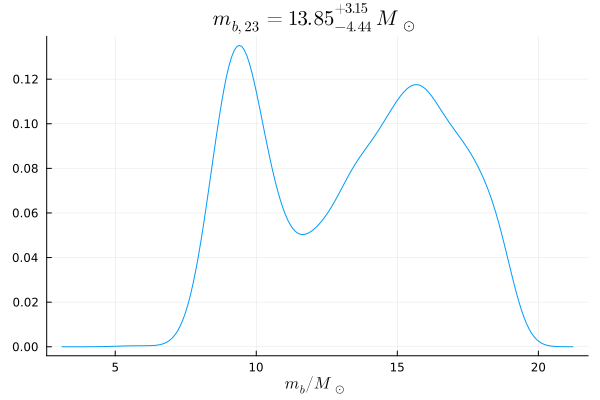

In [13]:
x = vec(trace.posterior[:mb23])
l = quantile(x, 0.16)
m = quantile(x, 0.5)
h = quantile(x, 0.84)

density(x, xlabel=L"m_b / M_\odot", label=nothing)
p = title!(@sprintf("\$m_{b,23} = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", m, h-m, m-l))

p

It looks like one of the peaks is at $9 \, M_\odot$; let's pull that out, and also the other one:

In [14]:
xx = map(trace.posterior[:mb12], trace.posterior[:mb23]) do mb12, mb23
    d12 = abs(mb12 - 9.25)
    d23 = abs(mb23 - 9.25)

    if d12 < d23
        mb12, mb23
    else
        mb23, mb12
    end
end
mb_9 = map(x -> x[1], xx)
mb_other = map(x -> x[2], xx);

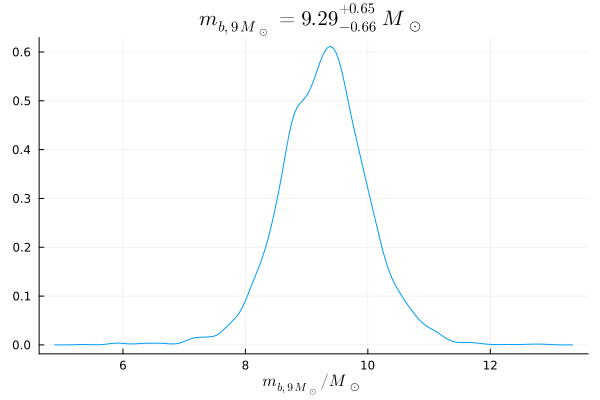

In [15]:
x = vec(mb_9)
title = @sprintf("\$m_{b,9\\,M_\\odot} = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", quantile(x, 0.5), quantile(x, 0.84) - quantile(x, 0.5), quantile(x, 0.5) - quantile(x, 0.16))
density(vec(x), xlabel=L"m_{b,9\,M_\odot} / M_\odot", label=nothing, title=title)

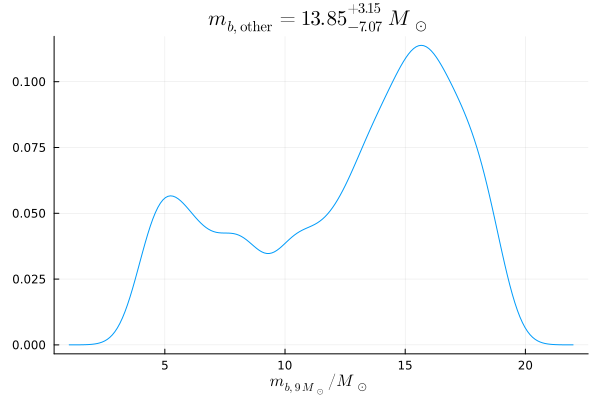

In [16]:
x = vec(mb_other)
title = @sprintf("\$m_{b,\\mathrm{other}} = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", quantile(x, 0.5), quantile(x, 0.84) - quantile(x, 0.5), quantile(x, 0.5) - quantile(x, 0.16))
density(vec(x), xlabel=L"m_{b,9\,M_\odot} / M_\odot", label=nothing, title=title)

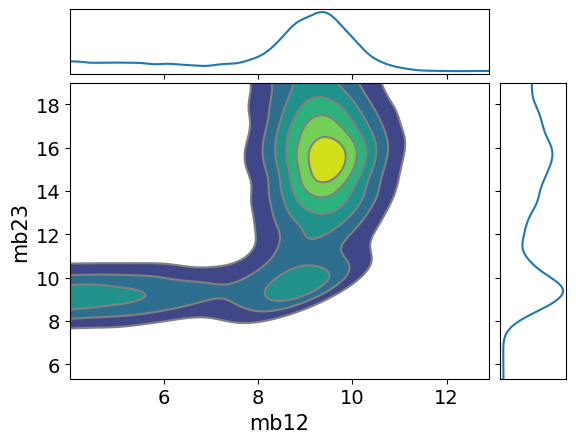

2×2 Matrix{PyCall.PyObject}:
 PyObject <Axes: >                              PyObject None
 PyObject <Axes: xlabel='mb12', ylabel='mb23'>  PyObject <Axes: >

In [17]:
plot_pair(trace, var_names=["mb12", "mb23"], marginals=true, kind="kde")

In [18]:
function m1pct(ms, f)
    fm = f.(ms)
    cfm = cumtrapz(ms, fm)

    ms[argmin(abs.(cfm/cfm[end] .- 0.01))]
end

m1pct (generic function with 1 method)

In [19]:
m1pct_m1 = map(dNdm1) do dN
    m1pct(ms, dN)
end
m1pct_m2 = map(dNdm2) do dN
    m1pct(ms, dN)
end
m1pct_pl = map(dNdm_pl) do dN
    m1pct(ms, dN)
end;

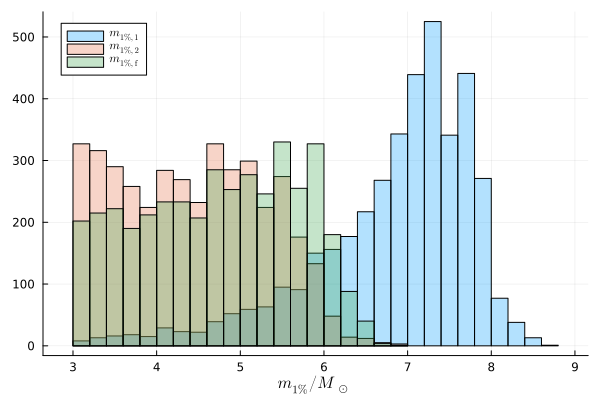

In [20]:
histogram(vec(m1pct_m1), label=L"m_{1\%,1}", xlabel=L"m_{1\%} / M_\odot", fillalpha=0.3)
histogram!(vec(m1pct_m2), label=L"m_{1\%,2}", fillalpha=0.3)
histogram!(vec(m1pct_pl), label=L"m_{1\%,\mathrm{f}}", fillalpha=0.3)

Let's do some model checking.  First, we plot the population-informed posteriors for $m_1$ and $m_2$:

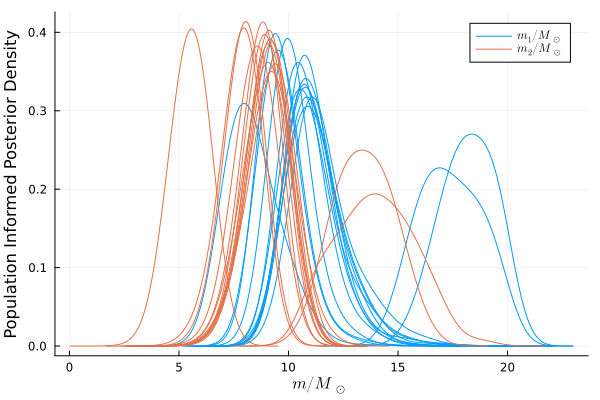

In [22]:
p = plot(xlabel=L"m / M_\odot", ylabel="Population Informed Posterior Density")
m1label = L"m_1 / M_\odot"
for n in DimensionalData.index(trace.posterior, :gwnames)
    p = density!(vec(trace.posterior.m1s_popwt[gwnames=At(n)]), color=1, label=m1label, bandwidth=0.75)
    m1label = nothing
end
m2label = L"m_2 / M_\odot"
for n in DimensionalData.index(trace.posterior, :gwnames)
    p = density!(vec(trace.posterior.m2s_popwt[gwnames=At(n)]), color=2, label=m2label, bandwidth=0.75)
    m2label = nothing
end
p

I bet our inference about the minimum BH mass is being driven by that one outlier.  Let's look:

In [24]:
nmin = ""
mmin = Inf
for n in DimensionalData.index(trace.posterior, :gwnames)
    mm = minimum(trace.posterior.m2s_popwt[gwnames=At(n)])

    if mm < mmin
        mmin = mm
        nmin = n
    end
    println("minimum($(n), m2): $(mm)")
end

minimum(GW190707_093326, m2): 6.413683750508289
minimum(GW190708_232457, m2): 10.39608884738505
minimum(GW190720_000836, m2): 5.906136583366412
minimum(GW190728_064510, m2): 5.62079357352409
minimum(GW190924_021846, m2): 3.0285331850587087
minimum(GW190930_133541, m2): 5.954066140805375
minimum(GW191103_012549, m2): 5.653935324801454
minimum(GW191105_143521, m2): 5.5308391594166295
minimum(GW191126_115259, m2): 5.9098653739637035
minimum(GW191129_134029, m2): 4.665401237325922
minimum(GW191204_171526, m2): 6.56129943737071
minimum(GW191216_213338, m2): 5.383393609004309
minimum(GW200202_154313, m2): 5.765694419569753
minimum(GW200225_060421, m2): 10.765225169021784
minimum(GW200316_215756, m2): 6.110385977420201


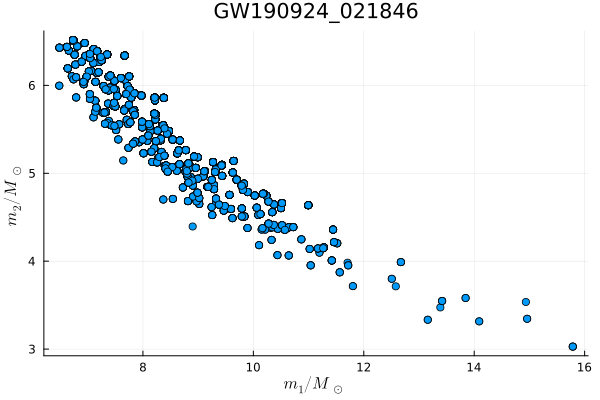

In [26]:
scatter(vec(trace.posterior.m1s_popwt[gwnames=At(nmin)]), vec(trace.posterior.m2s_popwt[gwnames=At(nmin)]), label=nothing, xlabel=L"m_1 / M_\odot", ylabel=L"m_2 / M_\odot", title=nmin)